In [20]:
%load_ext autoreload
%autoreload 2

import os, sys

import pvlib
from pvlib import pvsystem
print('pvlib version: {}'.format(pvlib.__version__))

# import pvsyst module based on ipython running in /docs/
cwd = os.getcwd()
print('current workign directory: {}'.format(cwd))
sys.path.append(os.path.dirname(cwd))  # append to path to be able to import module
sys.path.append(os.path.dirname(os.path.dirname(cwd))) # append to path to be able to import module

import pvsyst
print('pvsyst module path: {}'.format(pvsyst.__file__))

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18,18))

import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pvlib version: 0.6.1
current workign directory: C:\Users\frivollier\OneDrive\Software\pvsyst_tools\docs
pvsyst module path: C:\Users\frivollier\OneDrive\Software\pvsyst_tools\pvsyst\__init__.py


<Figure size 1296x1296 with 0 Axes>

In [21]:
# set PAN file path
import logging
logger = logging.getLogger('pysyst')
logger.setLevel(10)  # 5 for Verbose 10 for Debug

pan_dir = r'data'  # directory of PAN files}
pan = os.path.join(pan_dir,'CS3U-365P_MIX_CSIHE_EXT_V6_70_1500V_2018Q2.PAN')  # example PAN file

In [25]:
# parse .PAN file into dict 
module_parameters = pvsyst.pan_to_module_param(pan)  # return two dicts

print(module_parameters)

DEBUG:pysyst:{'pvModule': {'ARev': '3.200',
              'Absorb': '0.90',
              'AirMassRef': '1.500',
              'BRev': '11.040',
              'CellArea': '122.8',
              'Flags': '$00500443',
              'GRef': '1000',
              'Gamma': '0.952',
              'Imp': '9.180',
              'Isc': '9.750',
              'NCelP': '2',
              'NCelS': '72',
              'NDiode': '3',
              'PNom': '365.0',
              'PNomTolLow': '0.00',
              'PNomTolUp': '1.40',
              'RDiode': '0.010',
              'RSerie': '0.239',
              'RShunt': '600',
              'RelEffic200': '-3.40',
              'RelEffic400': '-1.20',
              'RelEffic800': '0.70',
              'Rp_0': '2500',
              'Rp_Exp': '5.50',
              'SandiaAMCorr': '50.000',
              'SubModuleLayout': 'slTwinHalfCells',
              'TRef': '25.0',
              'Technol': 'mtSiPoly',
              'VMaxIEC': '1500',
          

{'Manufacturer': 'Canadian Solar Inc.', 'Model': 'CS3U-365P 1500V HE', 'Technol': 'mtSiPoly', 'DataSource': 'Manufacturer 2018 TUV-SUD data', 'YearBeg': '2018', 'Comment': 'www.canadiansolar.com', 'Width': 0.992, 'Height': 2.0, 'Depth': 0.035, 'Weight': 22.5, 'RelEffic800': 0.7, 'RelEffic400': -1.2, 'RelEffic200': -3.4, 'NCelS': 72, 'NCelP': 2, 'NDiode': 3, 'GRef': 1000.0, 'TRef': 25.0, 'PNom': 365.0, 'PNomTolLow': '0.00', 'PNomTolUp': '1.40', 'Isc': 9.75, 'Voc': 47.2, 'Imp': 9.18, 'Vmp': 39.8, 'muISC': 4.88, 'muVocSpec': -137.0, 'mIsc_percent': 0.05005128205128205, 'mVoc_percent': -0.2902542372881356, 'muPmpReq': -0.37, 'RShunt': 600.0, 'Rp_0': 2500.0, 'Rp_Exp': 5.5, 'RSerie': 0.239, 'Gamma': 0.952, 'muGamma': -0.0004, 'REM_Str_1': 'Cell: Poly Gen4', 'REM_Str_2': 'Frame: Anodized aluminium alloy', 'REM_Str_3': 'Structure: 3.2mm Glass / EVA / Backsheet', 'REM_Str_4': 'Connections: Cable, T4 series or UTX or MC4 series', 'IAM_Point_1': '10.0,1.00000', 'IAM_Point_2': '20.0,1.00000', 'IAM

In [23]:
module_parameters["IAM"]

array([[10.  , 20.  , 30.  , 40.  , 50.  , 60.  , 70.  , 80.  , 90.  ],
       [ 1.  ,  1.  ,  1.  ,  0.99,  0.99,  0.97,  0.92,  0.76,  0.  ]])

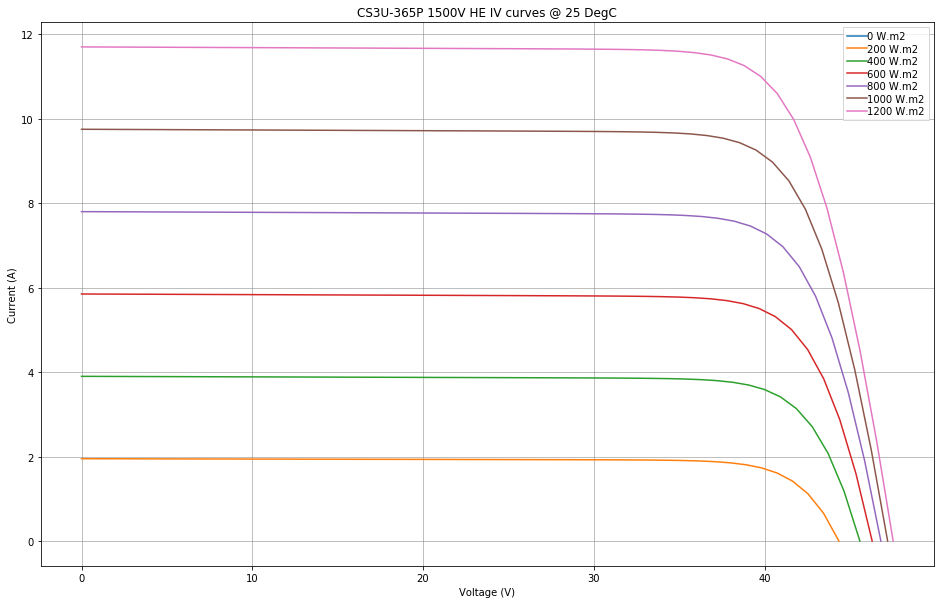

In [26]:
# example single diode model using calcparams_pvsyst
#return IV curve plot
def iplot_iv_vs_irradiances(module_parameters, irradiances = range(0,1300,200), Tcell = 25):
    #IV curve compute paramaters
    Gs = irradiances
    IV = [None]*len(Gs)

    for idx, g in enumerate(Gs):
        IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_pvsyst(effective_irradiance = g, temp_cell = Tcell,
                                                         alpha_sc = module_parameters['alpha_sc'],
                                                         gamma_ref = module_parameters['gamma_ref'],
                                                         mu_gamma = module_parameters['mu_gamma'],
                                                         I_L_ref = module_parameters['I_L_ref'],
                                                         I_o_ref = module_parameters['I_o_ref'],
                                                         R_sh_ref = module_parameters['R_sh_ref'],
                                                         R_sh_0 = module_parameters['R_sh_0'],
                                                         R_s = module_parameters['R_s'],
                                                         cells_in_series = module_parameters['cells_in_series'])
        
        IV[idx] = pvsystem.singlediode(IL, I0, Rs, Rsh, nNsVth, ivcurve_pnts=50)

    # Print IV Curves     
    plt.figure(figsize=(16, 10))
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.title('{} IV curves @ {} DegC'.format(module_parameters['module_name'], Tcell))

    labels = []
    for idx, v in enumerate(IV):
        plt.plot(v['v'],v['i'])
        labels.append('{} W.m2'.format(Gs[idx]))
    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

    plt.legend(labels, ncol=1, loc='upper right', 
               bbox_to_anchor=[1, 1], 
               columnspacing=2.0, labelspacing=0.25,
               handletextpad=0.0, handlelength=2,
               fancybox=False, shadow=False)

    plt.show()
    
    
iplot_iv_vs_irradiances(module_parameters)

Temp:-10 C IL:9.579 I0:3.7260145657090056e-14 Rs:0.239 Rsh:600.000 nNsVth:1.577
    1000W/m2 | Voc:52.32V | Isc: 9.58A | Pmp:411.11W | Vmp:44.87V | Imp: 9.16A
Temp:-5 C IL:9.604 I0:1.0130327860410785e-13 Rs:0.239 Rsh:600.000 nNsVth:1.604
    1000W/m2 | Voc:51.60V | Isc: 9.60A | Pmp:404.78W | Vmp:44.11V | Imp: 9.18A
Temp:0 C IL:9.628 I0:2.6669754138720847e-13 Rs:0.239 Rsh:600.000 nNsVth:1.630
    1000W/m2 | Voc:50.88V | Isc: 9.62A | Pmp:398.39W | Vmp:43.36V | Imp: 9.19A
Temp:5 C IL:9.652 I0:6.810613430111018e-13 Rs:0.239 Rsh:600.000 nNsVth:1.657
    1000W/m2 | Voc:50.16V | Isc: 9.65A | Pmp:391.94W | Vmp:42.60V | Imp: 9.20A
Temp:10 C IL:9.677 I0:1.6897689416568725e-12 Rs:0.239 Rsh:600.000 nNsVth:1.683
    1000W/m2 | Voc:49.43V | Isc: 9.67A | Pmp:385.43W | Vmp:41.83V | Imp: 9.21A
Temp:15 C IL:9.701 I0:4.079397808582438e-12 Rs:0.239 Rsh:600.000 nNsVth:1.709
    1000W/m2 | Voc:48.69V | Isc: 9.70A | Pmp:378.86W | Vmp:41.08V | Imp: 9.22A
Temp:20 C IL:9.726 I0:9.596258040116847e-12 Rs:0.239 Rs

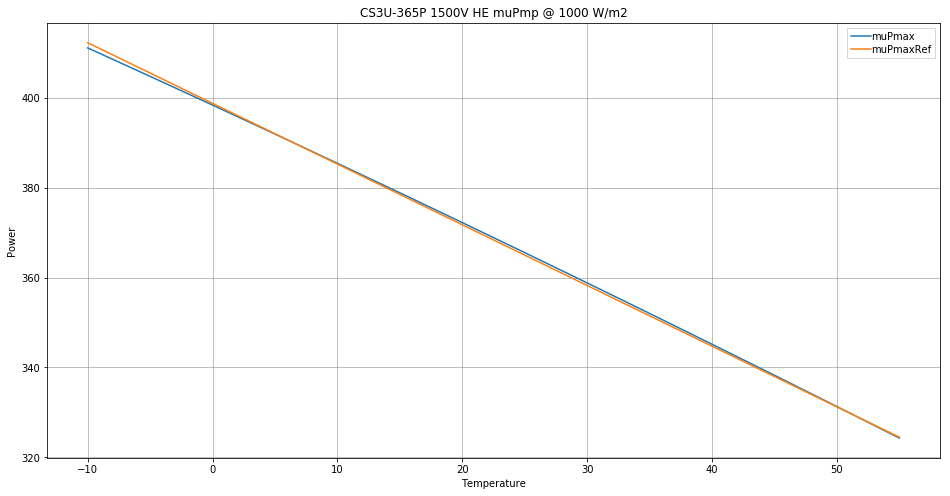

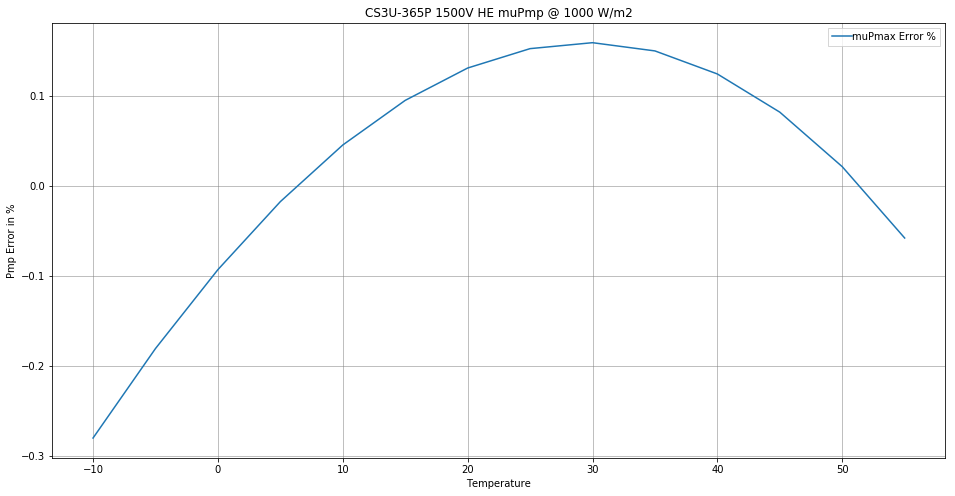

In [27]:
#return plotly object of gamma optimisatino mu_gamma
def iplot_gamma_coef(module_parameters):

    #Display mu_Pmax optimizatino
    temperatures = range(-10,60,5)

    g = 1000
    #IV curve compute paramaters

    IV = [None]*len(temperatures)
    for idx, t in enumerate(temperatures):
        IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_pvsyst(effective_irradiance = g, temp_cell = temperatures[idx],
                                                         alpha_sc = module_parameters['alpha_sc'],
                                                         gamma_ref = module_parameters['gamma_ref'],
                                                         mu_gamma = module_parameters['mu_gamma'],
                                                         I_L_ref = module_parameters['I_L_ref'],
                                                         I_o_ref = module_parameters['I_o_ref'],
                                                         R_sh_ref = module_parameters['R_sh_ref'],
                                                         R_sh_0 = module_parameters['R_sh_0'],
                                                         R_s = module_parameters['R_s'],
                                                         cells_in_series = module_parameters['cells_in_series'])

        IV[idx] = pvsystem.singlediode(IL, I0, Rs, Rsh, nNsVth, ivcurve_pnts=50)
        print('Temp:{} C IL:{:0.3f} I0:{} Rs:{:0.3f} Rsh:{:0.3f} nNsVth:{:0.3f}'.format(t,IL,I0,Rs,Rsh,nNsVth))
        print('    {:4.0f}W/m2 | Voc:{:5.2f}V | Isc:{:5.2f}A | Pmp:{:5.2f}W | Vmp:{:5.2f}V | Imp:{:5.2f}A'.format(g,
                                                                                   IV[idx]['v_oc'],
                                                                                   IV[idx]['i_sc'],
                                                                                   IV[idx]['p_mp'],
                                                                                   IV[idx]['v_mp'],
                                                                                   IV[idx]['i_mp']))

    #print pf percent Pmp / Temp    
    
    x = [None]*len(temperatures)
    y = [None]*len(temperatures) #for slingle diode model values
    y1 = [None]*len(temperatures) #for reference value

    for idx, v in enumerate(IV):
        # print the name of the regiment
        x[idx] = temperatures[idx]
        y[idx] = v['p_mp']
        y1[idx] = module_parameters['Pmpp'] * (1+(module_parameters['mPmpp']/100)*(temperatures[idx] - 25))

    plt.figure(figsize=(16, 8))
    plt.xlabel('Temperature')
    plt.ylabel('Power')
    plt.title('{} muPmp @ {} W/m2'.format(module_parameters['module_name'],g))

    labels = []
    plt.plot(x,y)
    labels.append('muPmax')
    plt.plot(x,y1)
    labels.append('muPmaxRef') 
    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

    plt.legend(labels, ncol=1, loc='upper right', 
               bbox_to_anchor=[1, 1], 
               columnspacing=2.0, labelspacing=0.25,
               handletextpad=0.0, handlelength=2,
               fancybox=False, shadow=False)

    plt.show()


    #Print ERROR % of Pmp / Rmp Expected
    x = [None]*len(temperatures)
    y = [None]*len(temperatures) #for slingle diode model values
    y1 = [None]*len(temperatures) #for reference value

    for idx, v in enumerate(IV):
        # print the name of the regiment
        x[idx] = temperatures[idx]
        actual = v['p_mp']
        reference = module_parameters['Pmpp'] * (1+((module_parameters['mPmpp']/100)*(temperatures[idx] - 25)))
        y[idx] = ((actual - reference)/reference)*100


    plt.figure(figsize=(16, 8))
    plt.xlabel('Temperature')
    plt.ylabel('Pmp Error in %')
    plt.title('{} muPmp @ {} W/m2'.format(module_parameters['module_name'],g))

    labels = []
    plt.plot(x,y)
    labels.append('muPmax Error %')

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')

    plt.legend(labels, ncol=1, loc='upper right', 
               bbox_to_anchor=[1, 1], 
               columnspacing=2.0, labelspacing=0.25,
               handletextpad=0.0, handlelength=2,
               fancybox=False, shadow=False)

    plt.show()
    
iplot_gamma_coef(module_parameters)

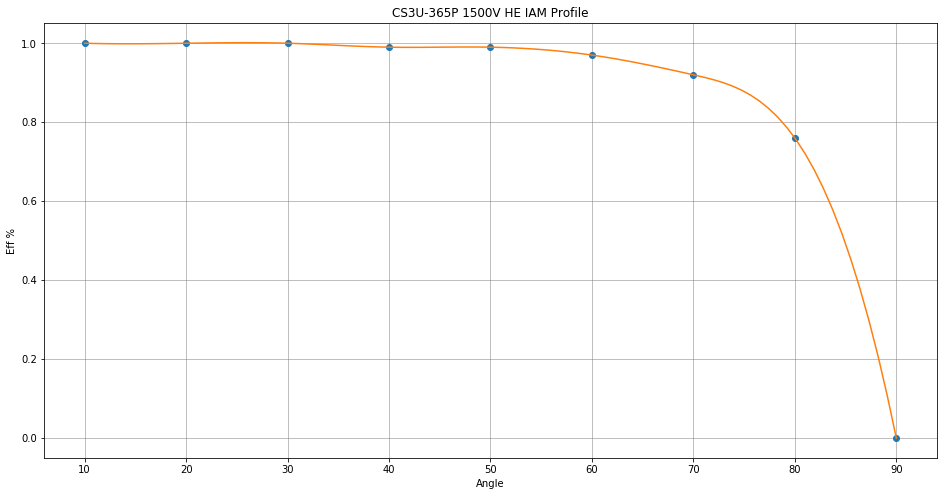

In [28]:
# IAM profile
from scipy.interpolate import interp1d

x = module_parameters['IAM'][0]
y = module_parameters['IAM'][1]

plt.figure(figsize=(16, 8))
plt.xlabel('Angle')
plt.ylabel('Eff %')
plt.title('{} IAM Profile'.format(module_parameters['module_name']))

plt.plot(x,y,'o')

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')

xcs = np.linspace(x.min(), x.max(), num=90, endpoint=True)

cs = interp1d(x, y, kind='cubic')
plt.plot(xcs,cs(xcs))

plt.show()